In [1]:
import numpy as np
from pathlib import Path
import pickle
from tqdm import tqdm
from numba import njit
from mpmath import coulombf
import jitr

import rose
from rose.training import multiple_formatter
from rose.training import latin_hypercube_sample

In [2]:
from matplotlib.ticker import StrMethodFormatter
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot as plt
from matplotlib import rcParams

colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]


plt.rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rcParams[
    "text.latex.preamble"
] = r"\usepackage{amssymb} \usepackage{amsmath} \usepackage{braket}"
plt.rc("text", usetex=True)

rcParams["legend.fontsize"] = 12
rcParams["font.size"] = 12
rcParams["font.weight"] = "normal"
rcParams["xtick.labelsize"] = 12.0
rcParams["ytick.labelsize"] = 12.0
rcParams["lines.linewidth"] = 2.0
rcParams["xtick.major.pad"] = "10"
rcParams["ytick.major.pad"] = "10"
rcParams["image.cmap"] = "BuPu"

## Get training and test solutions

In [3]:
params = np.load("./global_kd_params.npy")
lower_bound = np.min(params, axis=(0, 1))
lower_bound[0] = 1e-1
upper_bound = np.max(params, axis=(0, 1))
bounds = np.vstack([lower_bound, upper_bound]).T
frozen_params = bounds[:,1] == bounds[:,0]

In [4]:
bounds

array([[ 1.00000000e-01,  5.00000000e+01],
       [ 9.27253291e+02,  9.83439040e+02],
       [ 3.24862646e+01,  5.09474947e+01],
       [ 5.11769037e+00,  6.88789256e+00],
       [ 6.51777500e-01,  6.66498800e-01],
       [ 8.71746944e-02,  4.80302097e+00],
       [ 5.11769037e+00,  6.88789256e+00],
       [ 6.51777500e-01,  6.66498800e-01],
       [ 2.67172625e+00,  6.73960839e+00],
       [ 5.40178569e+00,  7.01274719e+00],
       [ 5.15620000e-01,  5.32014400e-01],
       [ 4.85189971e+00,  6.27749683e+00],
       [ 4.37414528e+00,  5.98346936e+00],
       [ 5.90000000e-01,  5.90000000e-01],
       [-3.74068604e-01, -5.36334245e-03],
       [ 4.37414528e+00,  5.98346936e+00],
       [ 5.90000000e-01,  5.90000000e-01]])

In [5]:
# use log(E) space
scaleE = 1.0
def forward_pspace_transform(sample):
    return np.hstack([ np.log(sample[0]/scaleE), sample[1:]])

def backward_pspace_transform(sample):
    return np.hstack([np.exp(sample[0])*scaleE, sample[1:]])

In [6]:
# sample parameters in log(E) space
log_energy_bounds = bounds.copy()
log_energy_bounds = np.vstack(
    [
        forward_pspace_transform(log_energy_bounds[:,0]).T,
        forward_pspace_transform(log_energy_bounds[:,1]).T,
    ]).T

In [7]:
n_train_log = 5000
n_train_lin = 5000
n_test = 500

train = latin_hypercube_sample(n_train_log, log_energy_bounds, seed=133)
test =latin_hypercube_sample(n_test, log_energy_bounds, seed=111)

# transform back to E space
train[:,0] = np.exp(train[:,0])
test[:,0] = np.exp(test[:,0])

# add some points that are not log distributed in energy space
train = np.vstack([train, rose.training.latin_hypercube_sample(n_train_lin, bounds, seed=19)] )

np.save("train.npy", np.asarray(train))
np.save("test.npy", np.asarray(test))

In [8]:
l_max=10
angles = np.linspace(0, np.pi, 200)
s_mesh = np.linspace(1e-2, 8 * np.pi, 1000)
domain = np.array([s_mesh[0], s_mesh[-1]])
s_0 = 7 * np.pi

In [9]:
interactions = rose.koning_delaroche.EnergizedKoningDelaroche(
    training_info=bounds,
    n_basis=15,
    l_max=l_max,
    n_train=10,
)
sae = rose.ScatteringAmplitudeEmulator.HIFI_solver(
    base_solver=rose.SchroedingerEquation.make_base_solver(
        s_0=s_0,
        domain=domain,
    ),
    interaction_space=interactions,
    angles=angles,
    s_mesh=s_mesh,
)

/home/kyle/umich/rose/src/rose/scattering_amplitude_emulator.py:354: RuntimeWarning: invalid value encountered in divide
  self.rutherford = 0.0 / (np.sin(self.angles / 2) ** 4)


In [10]:
free_solns = np.zeros((l_max+1, s_mesh.size), dtype=np.complex128)
for l in range(0,l_max+1):
    free_solns[l,:] = np.array([ coulombf(l,0,s) for s in s_mesh], dtype=np.complex128)
    free_solns[l,:] /= np.trapz( np.absolute( free_solns[l,:]), s_mesh )
np.save("free_solns.npy", free_solns)

In [11]:
pot_terms_up = np.array(
    [
        [interactions.interactions[l][0].tilde(s_mesh, sample) for l in range(0, l_max)]
        for sample in train
    ]
)
pot_terms_down = np.array(
    [
        [interactions.interactions[l][1].tilde(s_mesh, sample) for l in range(1, l_max)]
        for sample in train
    ]
)
np.save("pot_terms_up.npy", pot_terms_up)
np.save("pot_terms_down.npy", pot_terms_down)

In [12]:
hf_solns_up = np.zeros((len(train), l_max + 1, s_mesh.size), dtype=np.complex128)
hf_solns_down = np.zeros((len(train), l_max, s_mesh.size), dtype=np.complex128)

for i in tqdm(range(len(train))):
    sample = train[i,:]
    
    # solve
    solns = sae.exact_wave_functions(sample)
    hf_solns_up[i, ...] = np.array([x[0] for x in solns])
    hf_solns_down[i, ...] = np.array([x[1] for x in solns[1:]])

    # normalize
    row_norms = np.trapz( np.absolute(hf_solns_up[i,...]) , s_mesh, axis=1)
    hf_solns_up[i, ...] /= row_norms[:, np.newaxis]
    row_norms = np.trapz( np.absolute(hf_solns_down[i,...]) , s_mesh, axis=1)
    hf_solns_down[i, ...] /= row_norms[:, np.newaxis]
    
    # subtract phi_0
    hf_solns_up[i, ...] -= free_solns
    hf_solns_down[i, ...] -= free_solns[1:]

np.save("hf_solns_up.npy", hf_solns_up)
np.save("hf_solns_down.npy", hf_solns_down)

100%|███████████████████████████████████| 10000/10000 [3:00:53<00:00,  1.09s/it]


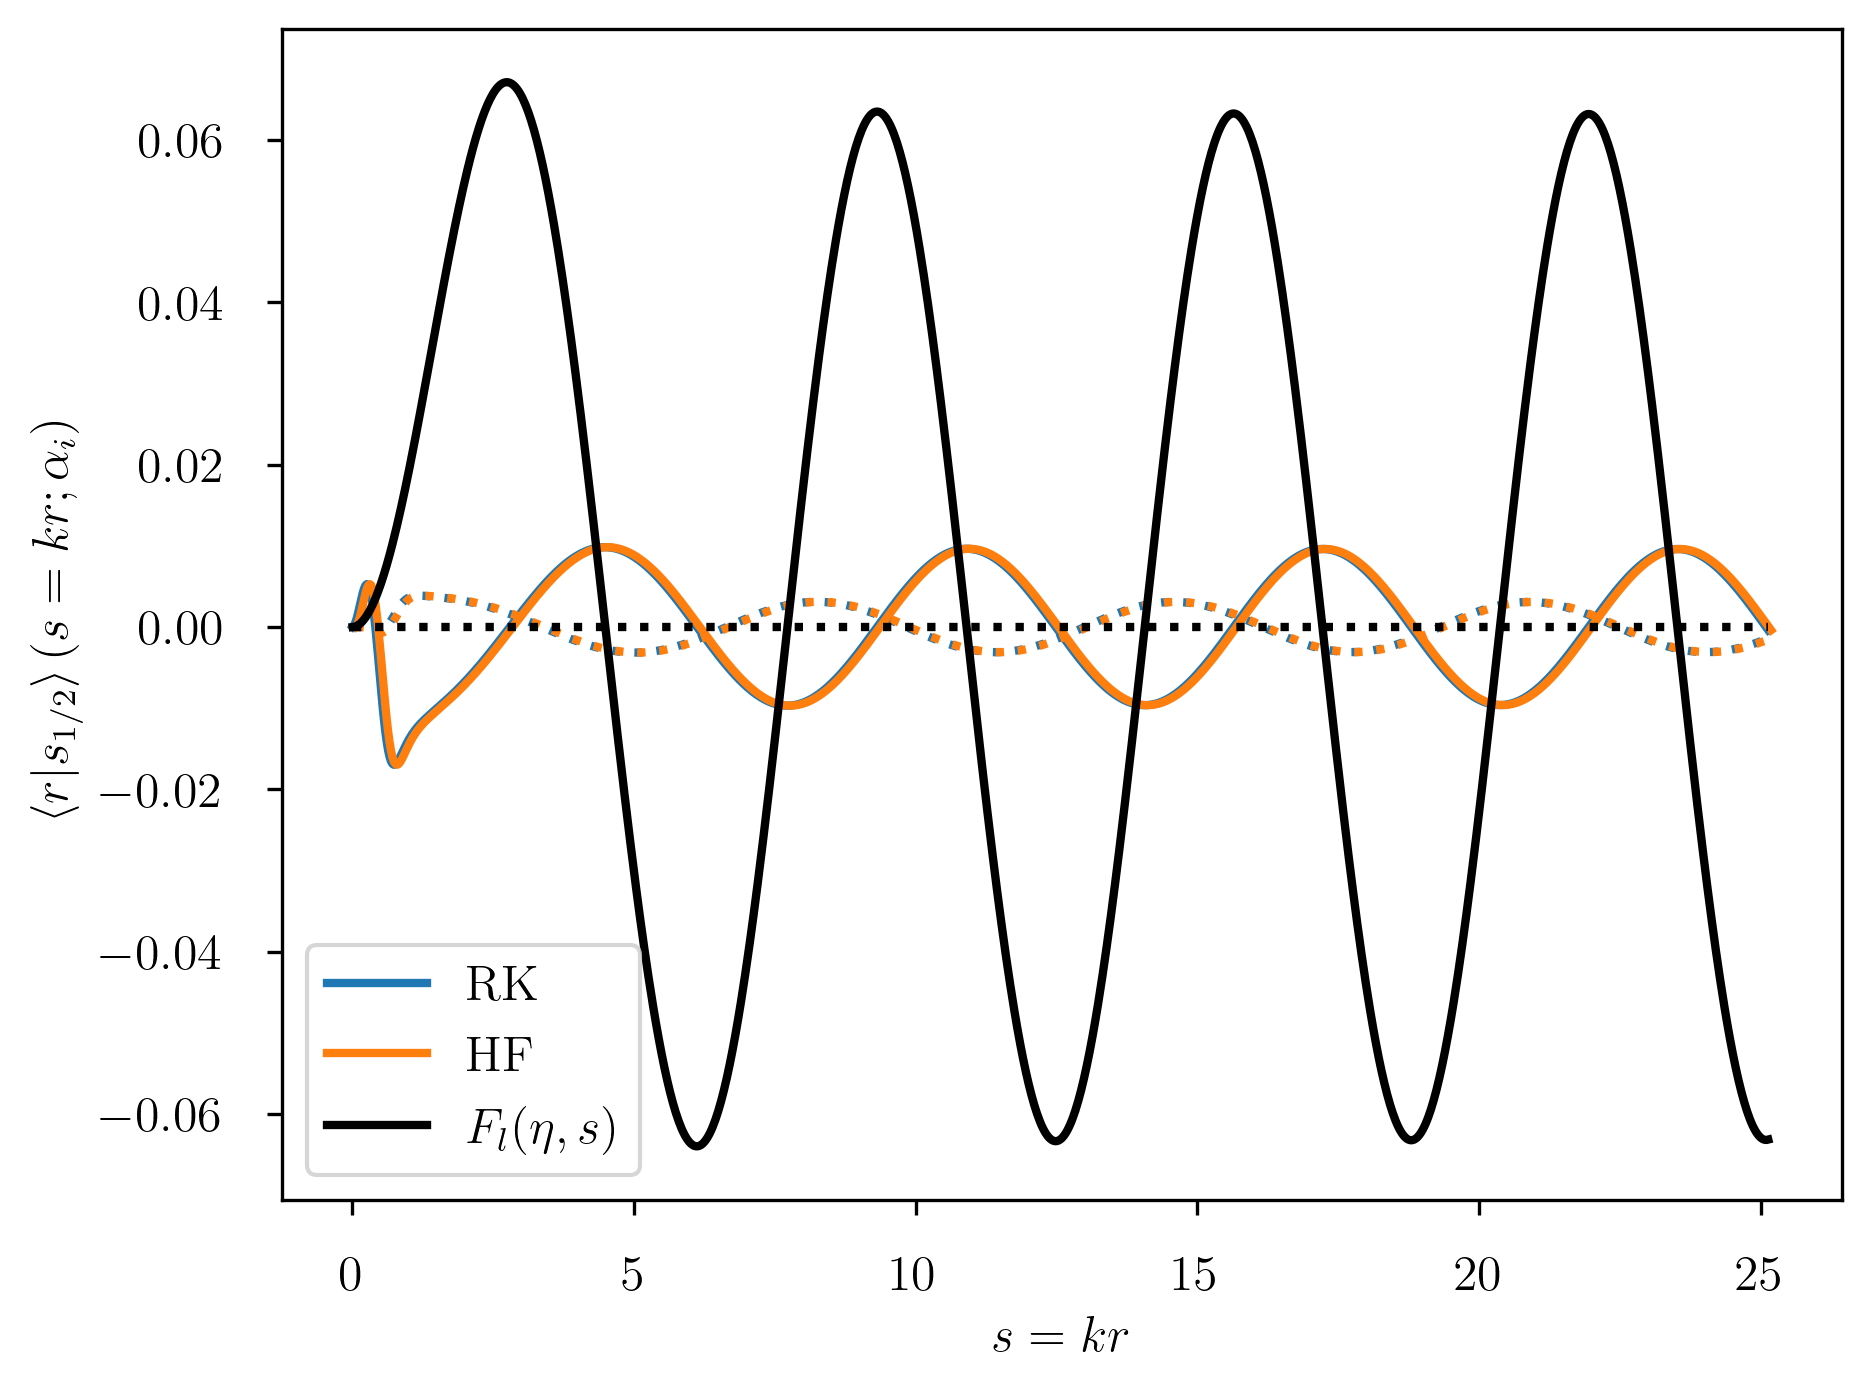

In [13]:
f = plt.figure(facecolor="white", dpi=300)
l = 1
for i, sample in enumerate(train[:1]):
    solns = sae.exact_wave_functions(sample)
    z = hf_solns_down[i,l-1,:]
    y = solns[l][1]
    y /= np.trapz(np.absolute(y), s_mesh)
    y -= free_solns[l,:]
    p = plt.plot(s_mesh, y.real, label="RK")[0]
    plt.plot(
        s_mesh,
        y.imag,
        ":",
        color=p.get_color(),
    )
    p = plt.plot(s_mesh+0.05, z.real, label="HF")[0]
    plt.plot(
        s_mesh+0.05,
        z.imag,
        ":",
        color=p.get_color(),
    )


plt.plot(s_mesh, free_solns[l,:].real, "k", label=r"$F_l(\eta, s)$")
plt.plot(s_mesh, free_solns[l,:].imag, ":k")

plt.xlabel(r"$s = kr$")
plt.ylabel(r"$\braket{  r | s_{1/2}}(s=kr; \alpha_i)$")
plt.legend()
plt.tight_layout()

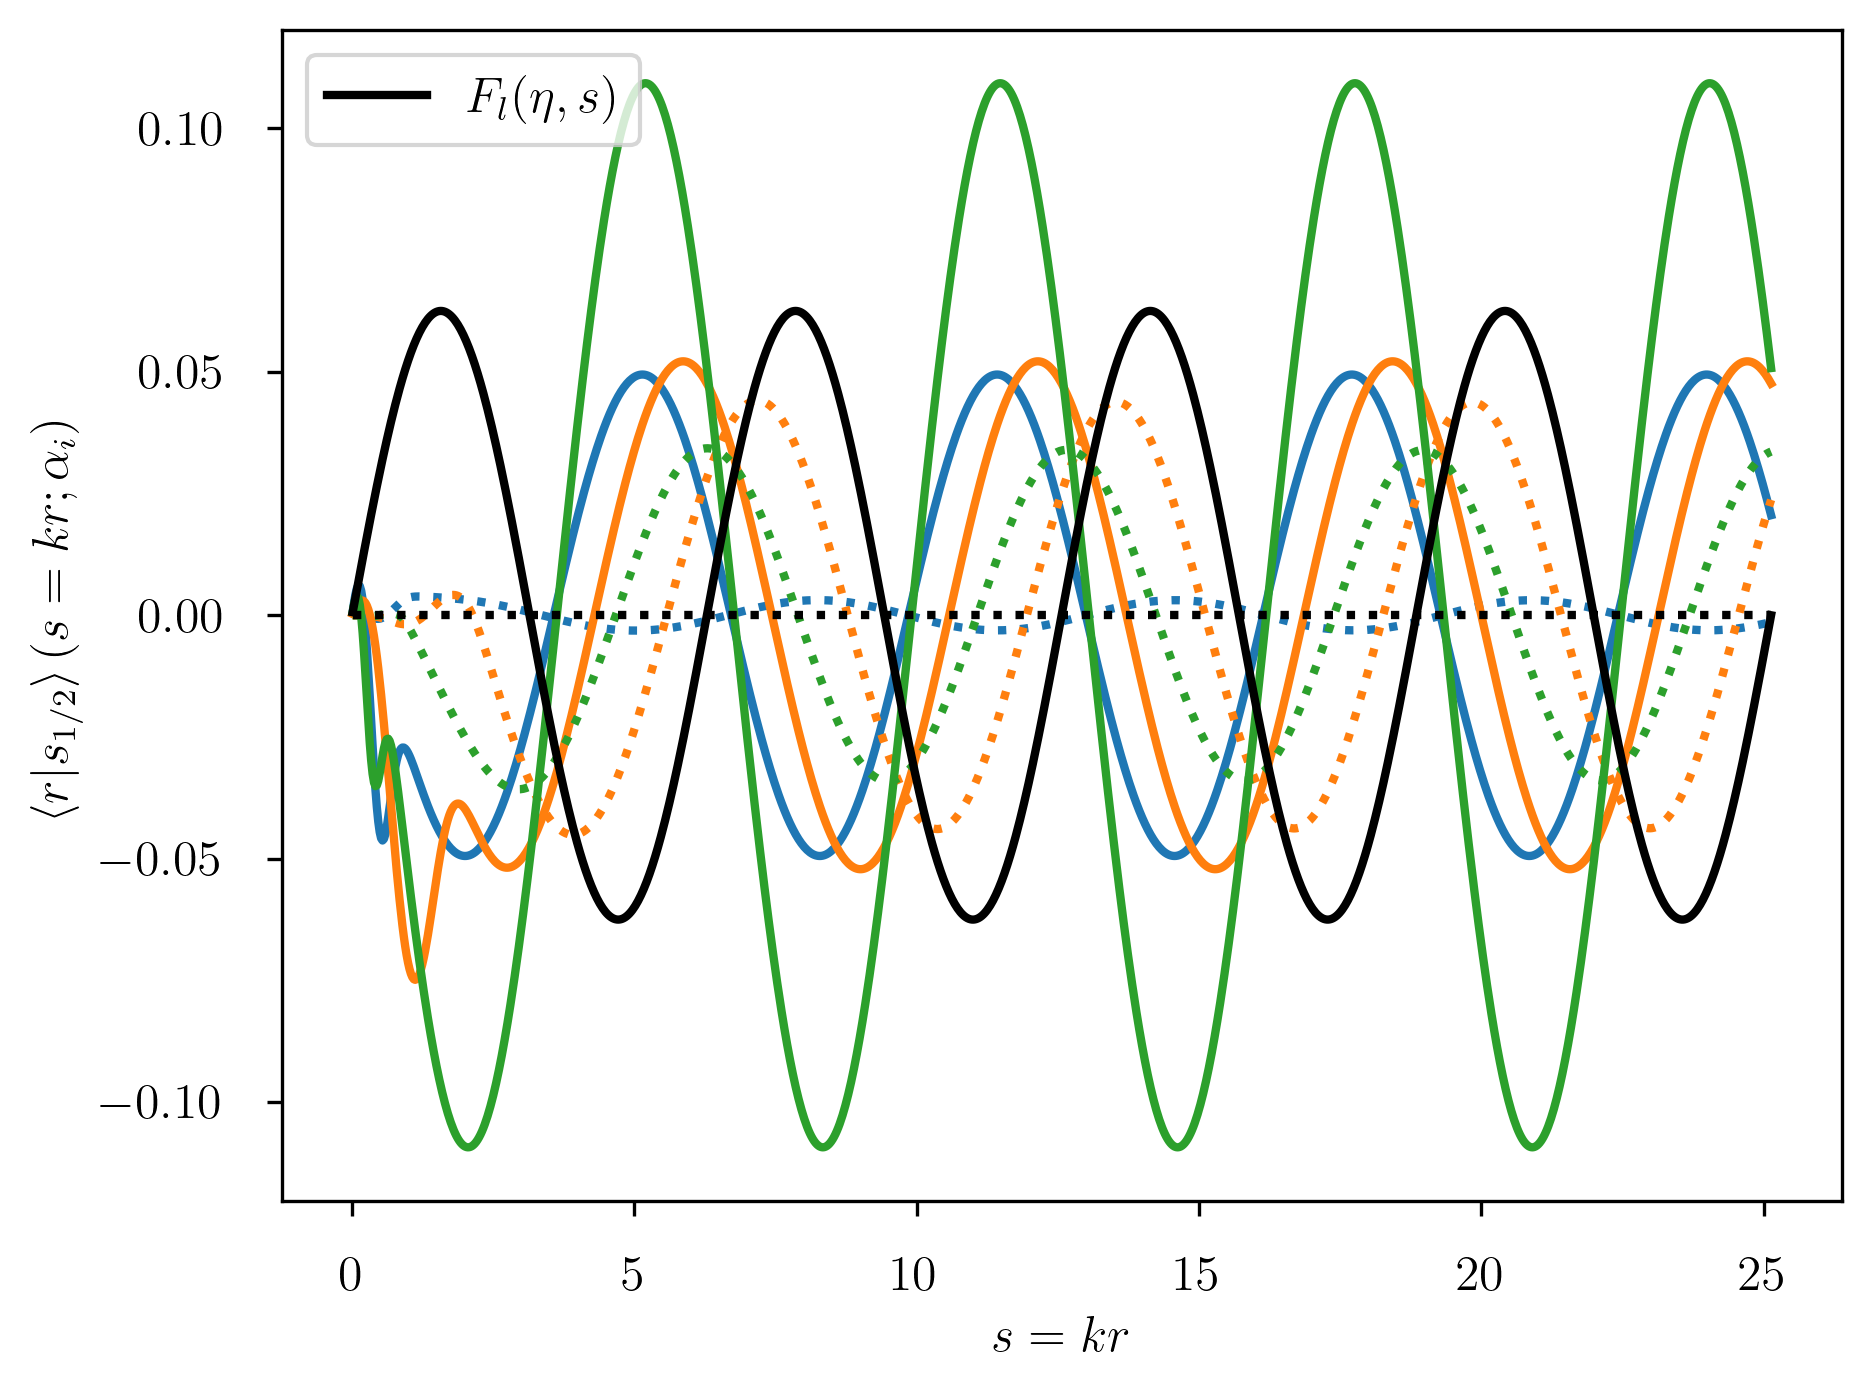

In [14]:
f = plt.figure(facecolor="white", dpi=300)
for i, sample in enumerate(train[:3]):
    p = plt.plot(s_mesh, hf_solns_up[i, 0, :].real)[0]
    plt.plot(
        s_mesh,
        hf_solns_down[i, 0, :].imag,
        ":",
        color=p.get_color(),
    )
plt.plot(s_mesh, free_solns[0,:].real, "k", label=r"$F_l(\eta, s)$")
plt.plot(s_mesh, free_solns[0,:].imag, ":k")

plt.xlabel(r"$s = kr$")
plt.ylabel(r"$\braket{  r | s_{1/2}}(s=kr; \alpha_i)$")
plt.legend()
plt.tight_layout()

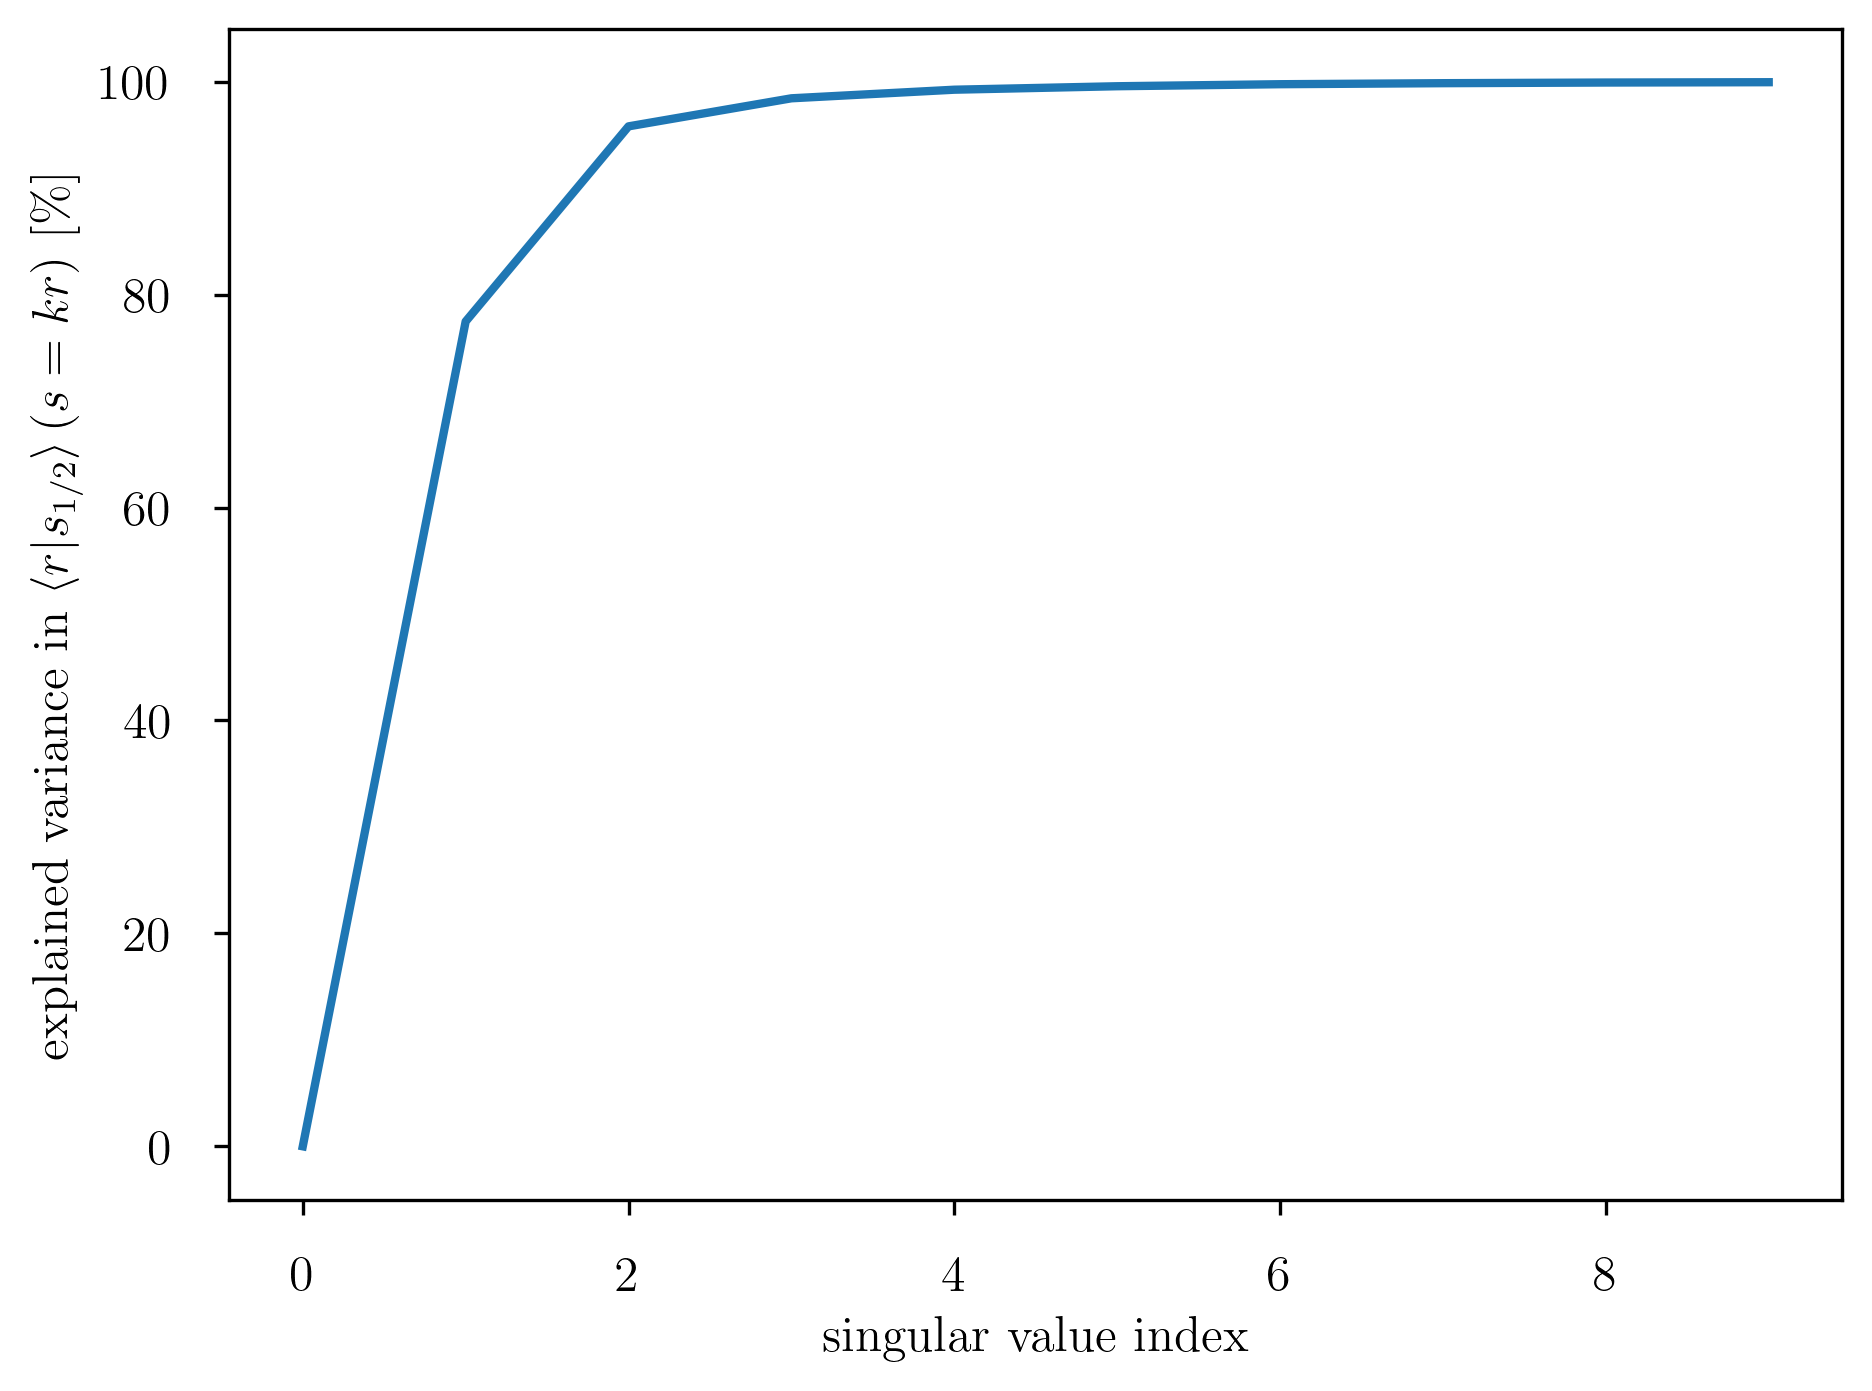

In [15]:
run_full_svd = True
if run_full_svd:
    Ufull, Sfull, Vhfull = np.linalg.svd(hf_solns_up[:,0,:].T, full_matrices=False)
    pct_var_expl = 100*np.array([np.sum(Sfull[:i]**2) for i in range(len(Sfull[:10]))]) / np.sum(Sfull**2)

    f = plt.figure(facecolor="white", dpi=300)
    plt.plot(
        list(range(len(Sfull[:10]))), 
        pct_var_expl,
    )
    plt.xlabel(r"singular value index")
    plt.ylabel(r"explained variance  in $\braket{ r | s_{1/2}}(s = kr)$ [\%]")
    plt.tight_layout()

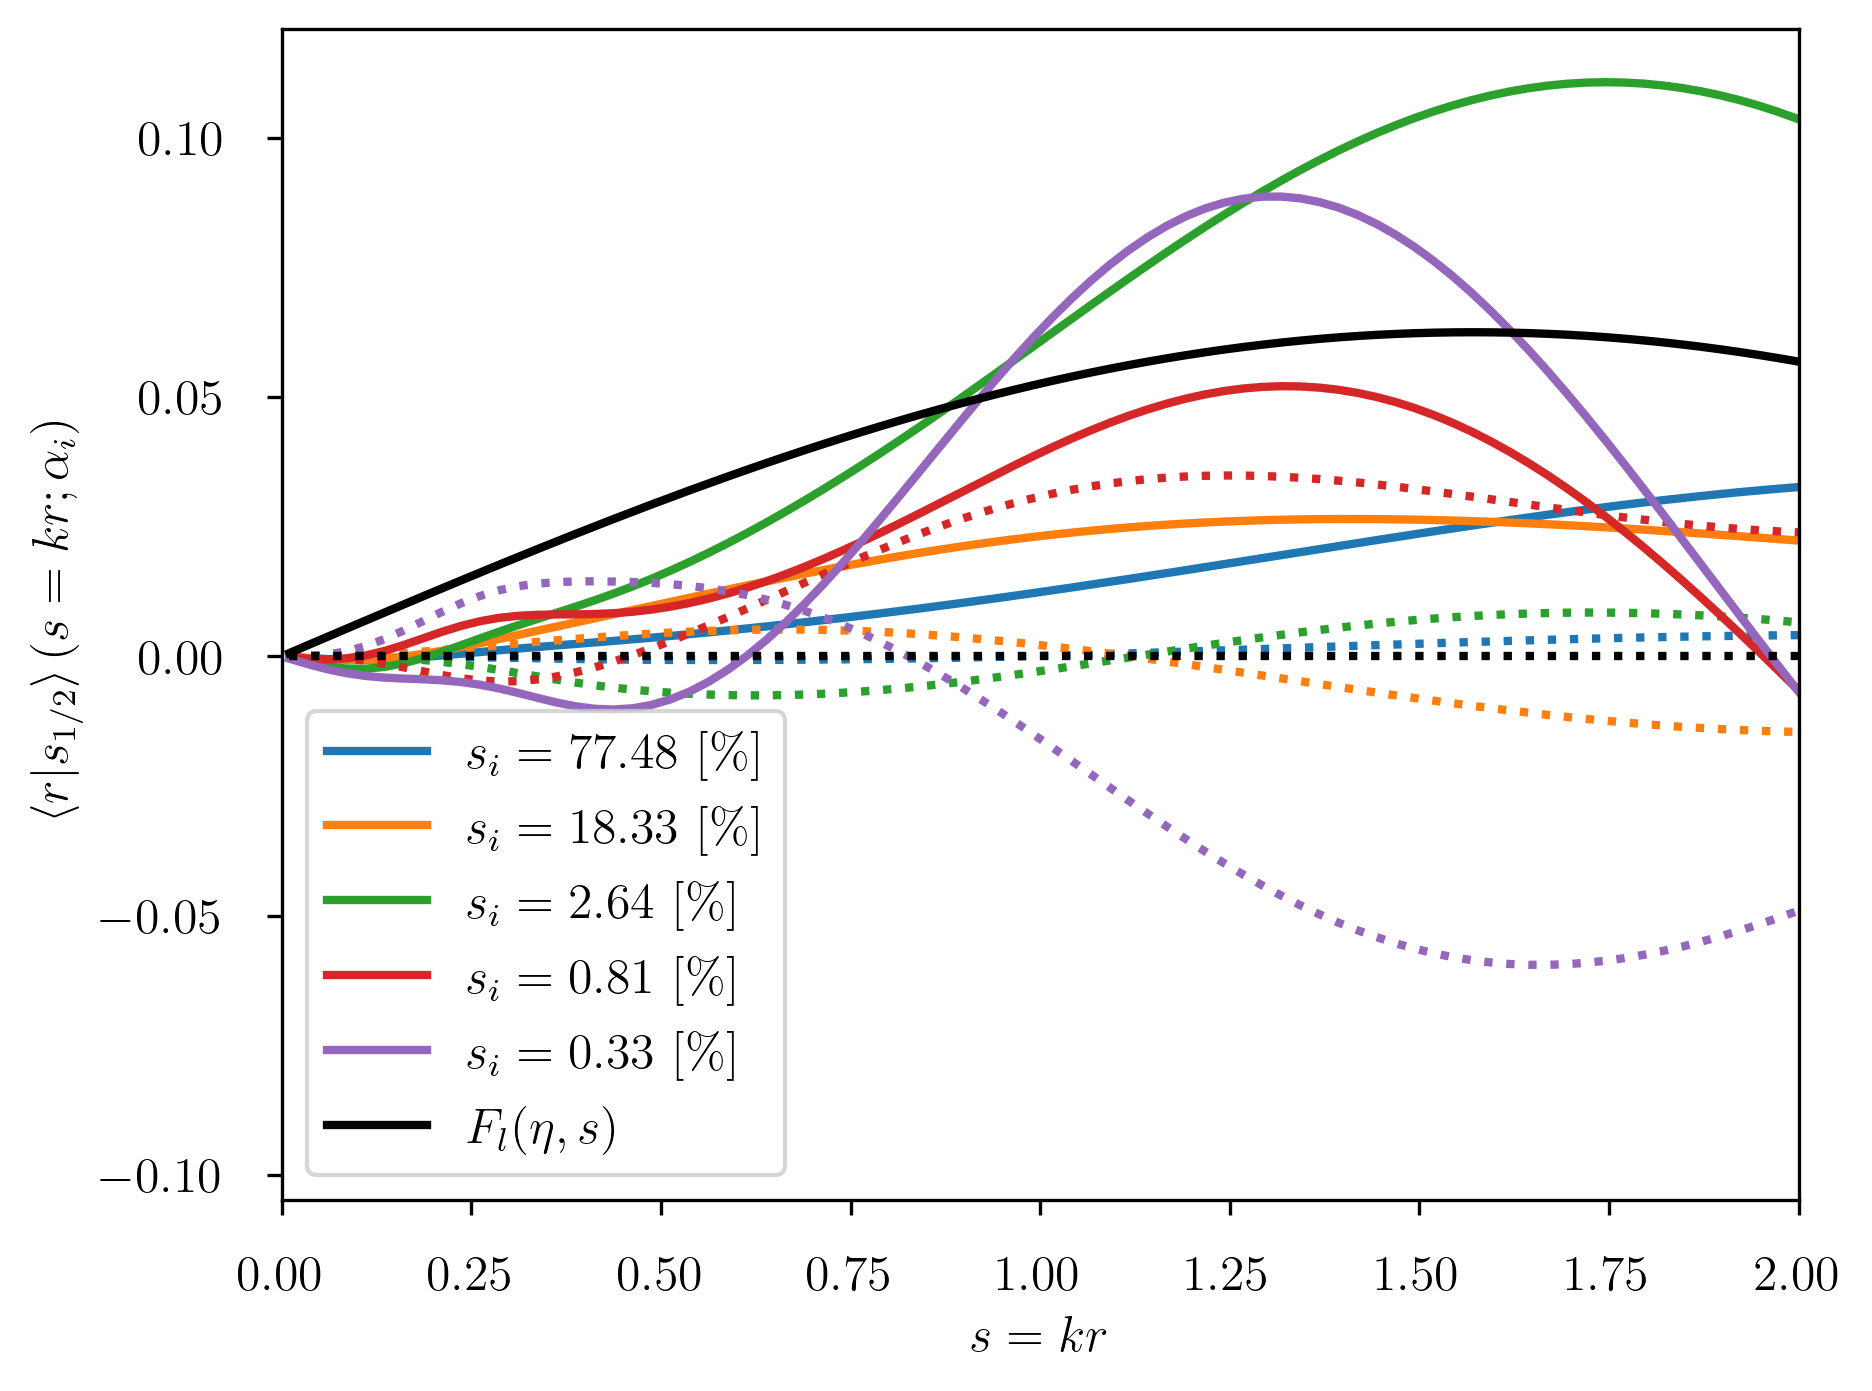

In [16]:
f = plt.figure(facecolor="white", dpi=300)
pct_var_expl = 100*Sfull**2/ np.sum(Sfull**2)

for i, sample in enumerate(train[:5]):
    pct = pct_var_expl[i]
    p = plt.plot(s_mesh, Ufull[:,i].real, label=f"$s_i = {pct:.2f}$ [\%]")[0]
    plt.plot(
        s_mesh,
        Ufull[:,i].imag,
        ":",
        color=p.get_color(),
    )
plt.plot(s_mesh, free_solns[0,:].real, "k", label=r"$F_l(\eta, s)$")
plt.plot(s_mesh, free_solns[0,:].imag, ":k")

plt.xlabel(r"$s = kr$")
plt.ylabel(r"$\braket{  r | s_{1/2}}(s=kr; \alpha_i)$")
plt.legend()
plt.xlim([0,2])

plt.tight_layout()

In [ ]:
interactions = rose.koning_delaroche.EnergizedKoningDelaroche(
    training_info=bounds,
    n_basis=15,
    l_max=l_max,
    rho_mesh=s_mesh,
)

In [ ]:
bases = []
for l in range(l_max + 1):
    l_bases = []
    l_bases.append(
        rose.CustomBasis(
            hf_solns_up[:, l, :].T,
            free_solns[l,:],
            s_mesh,
            5,
            use_svd=True,
            subtract_phi0=False,
            solver=rose.SchroedingerEquation(
                interaction=interactions.interactions[l][0],
                s_0=s_0,
                domain=domain,
            ),
        )
    )
    if l > 0:
        l_bases.append(
            rose.CustomBasis(
                hf_solns_down[:, l-1, :].T,
                free_solns[l,:],
                s_mesh,
                5,
                use_svd=True,
                subtract_phi0=False,
                solver=rose.SchroedingerEquation(
                    interaction=interactions.interactions[l][0],
                    s_0=s_0,
                    domain=domain,
                ),
            )
        )
    bases.append(l_bases)

In [ ]:
sae = rose.ScatteringAmplitudeEmulator(
    interaction_space=interactions,
    bases=bases,
    angles=angles,
    l_max=l_max,
    s_0=s_0,
)

In [ ]:
# get phase shifts of neighbors to first training sample
pse = sae.exact_phase_shifts(test[0])
psrbm = sae.emulate_phase_shifts(test[0])

from rose.training import compare_phase_shifts

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), dpi=600)
fig.patch.set_facecolor("white")

compare_phase_shifts(
    [pse, psrbm], ["Runge-Kutta", "RBM"], fig, ax1, ax2
)
ax1.set_ylim([-np.pi / 2, np.pi / 2])
ax2.set_ylim([-np.pi / 2, np.pi / 2])
plt.tight_layout()

In [ ]:
%%time
dsdo_rbm = []
for sample in test:
    dsdo_rbm.append( sae.emulate_dsdo(sample) )

In [ ]:
%%time 
dsdo_rk = []
for sample in tqdm(test):
    dsdo_rk.append( sae.exact_dsdo(sample) )

In [ ]:
np.save("dsdo_text_exact.npy", np.asarray(dsdo_rk))

In [ ]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(6, 3), dpi=1000)
fig.patch.set_facecolor("white")
for i, sample in enumerate(test[:10]):
    x = angles * 180 / np.pi
    
    # HIFI
    y_exact = dsdo_rk[i]

    # emulated
    y_emu = dsdo_rbm[i]

    p = ax.plot(x, y_emu, ":", alpha=0.5)
    ax.plot(x, y_exact, color=p[0].get_color(), alpha=0.5)

legend_styles = [
    Line2D([0], [0], color="k", linestyle=":", alpha=0.5),
    Line2D([0], [0], color="k", alpha=0.5),
]
ax.legend(legend_styles, ["RBM", "Runge-Kutta"])
plt.yscale("log")
plt.xlabel(r"s = kr", fontsize=12)
plt.ylabel(r"$U(s)$", fontsize=12)
plt.tight_layout()